# **0. Datos del grupo e Importación del dataset**

## 0.1 Datos del grupo y enlace al repositorio de Github

Esta práctica ha sido realizada por el **Grupo 5**, formado por:
* Izan Sánchez Álvado (NIA: 100495774)
* Alba Tello Marcos (NIA: 100495755)

El código completo con los respectivos commits se encuentra en el siguiente repositorio de GitHub:
https://github.com/albatellouc3m/Grupo5


## 0.2 Importación del dataset

In [128]:
import pandas as pd

datos_generales = pd.read_csv('./semillas.csv')

X = datos_generales.iloc[:, :-1].values  # Todas las columnas menos la última
y = datos_generales.iloc[:, -1].values   # La última columna

datos_generales.head()

,area,perimetro,compacidad,longitud,anchura,asimetria,surco,clase
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


# **1. Comprobación de scalers visualmente utilizando PCA**

En esta sección, utilizamos PCA para elegir entre tres scalers de forma visual. Para ello, definimos los tres scalers y vamos probando con cada uno a representarlo en 2 dimensiones (reduciendo los 7 atributos a 2). De entre los tres gráfico escogemos el que tenga una varianza mayor.

In [129]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


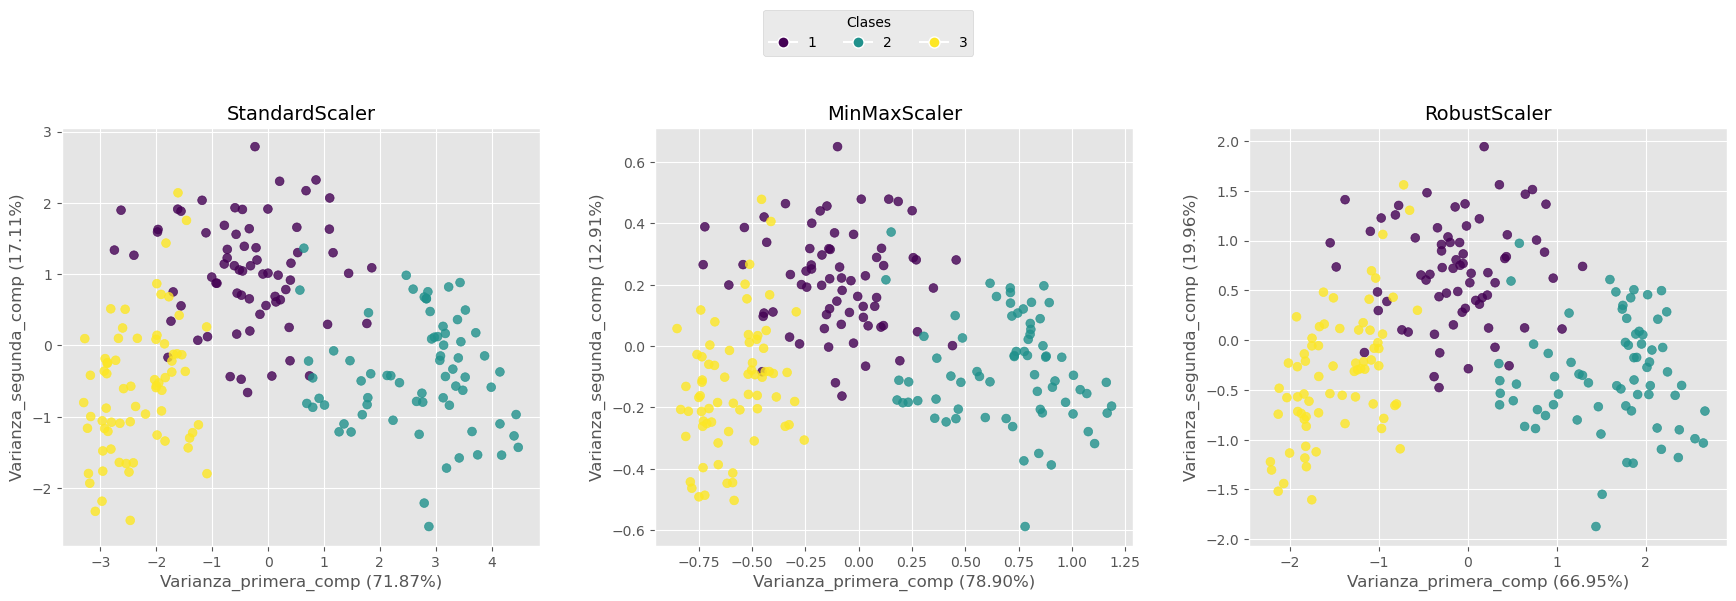

In [130]:
# MÉTODOS DE ESCALADO
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 3 columnas (Simplemente diseño, para poner los tres gráficos en horizontal)

for idx, (nombre, scaler) in enumerate(scalers.items()):
    
    # Escalamos los datos
    X_scaled = scaler.fit_transform(X)
    
    # Aplicamos PCA
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X_scaled)

    # Visualizamos en 2D
    scatter = axes[idx].scatter(
        X_reduced[:, 0],
        X_reduced[:, 1],
        c=pd.factorize(y)[0],
        cmap='viridis',
        s=40,
        alpha=0.8
    )
    
    axes[idx].set_title(f"{nombre}", fontsize=14)
    axes[idx].set_xlabel("Varianza_primera_comp ({:.2f}%)".format(pca.explained_variance_ratio_[0]*100))
    axes[idx].set_ylabel("Varianza_segunda_comp ({:.2f}%)".format(pca.explained_variance_ratio_[1]*100))
    axes[idx].grid(True)

# Leyenda común
etiquetas = sorted(set(y))
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=etiqueta,
               markerfacecolor=plt.cm.viridis(i / (len(etiquetas)-1)), markersize=8)
    for i, etiqueta in enumerate(etiquetas)
]

# Ajustamos la leyenda para separarla del gráfico
fig.legend(handles=handles, title="Clases", loc="upper center", ncol=len(etiquetas), fontsize=10, bbox_to_anchor=(0.5, 1.05))

# Ajustamos el layout para más espacio en la parte superior
plt.tight_layout(pad=3.0, rect=[0, 0, 1, 0.95])  # Mayor espacio entre el gráfico y la leyenda
plt.show()


Al analizar la información de estos gráficos, podemos llegar a la conclusión de que MinMax es el mejor scaler ya que la varianza es más alta en este. Por ello, para el resto del código, utilizaremos la reducción de los datos de entrada con el scaler MinMaxScaler.

In [131]:

# REDUCCIÓN DE DIMENSIONALIDAD CON PIPELINE MINMAX
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Usamos MinMaxScaler ya elegido anteriormente
    ('pca', PCA(n_components=2))
])

# Transformamos los datos
X_reduced = pipeline.fit_transform(X)
pca = pipeline.named_steps['pca']

# Convertimos X_reduced a DataFrame para visualización
df_reduced = pd.DataFrame(X_reduced, columns=['X1', 'X2'])

# Mostramos las primeras filas
print(df_reduced.head())


         X1        X2
0  0.075029  0.129691
1 -0.024301  0.364120
2 -0.149375  0.456497
3 -0.180881  0.440557
4  0.250589  0.441297


# **2. Aplicación de técnicas de clustering (K-Means, Dendogramas, DBSCAN)**

En esta sección, como el nombre indica, aplicaremos las técnicas estudiadas en clase sobre clustering comparandolas y sacando conclusiones.

## 2.1. K-Means

En esta sección de código, realizamos el escalado de los datos y entrenamos el modelo con el algoritmo de KMeans el cual tiene una serie de parámetros:

 - n_clusters: clusters que se generarán
 - n_init: veces que se repite el proceso
 - random_state: garantiza reproducibilidad de resultados

In [132]:
# Escalado de datos
# ==============================================================================
X_reduced_scaled = scale(X_reduced)

### 2.1.1 Elbow method para K-Means

Vamos a calcular la **inercia** para k entre 2 y 10, y buscar el codo.


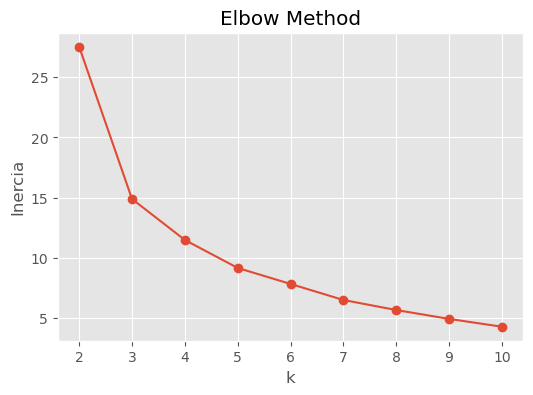

In [133]:
# Elbow method
inercia = []
Ks = range(2,11)
for k in Ks:
    km = KMeans(n_clusters=k, n_init=25, random_state=495774).fit(X_reduced)
    inercia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(Ks, inercia, '-o')
plt.xlabel('k'); plt.ylabel('Inercia')
plt.title('Elbow Method')
plt.show()




### 2.1.2 Silhouette analysis para K-Means

Para cada k entre 2 y 10, calculamos el silhouette score y lo graficamos.


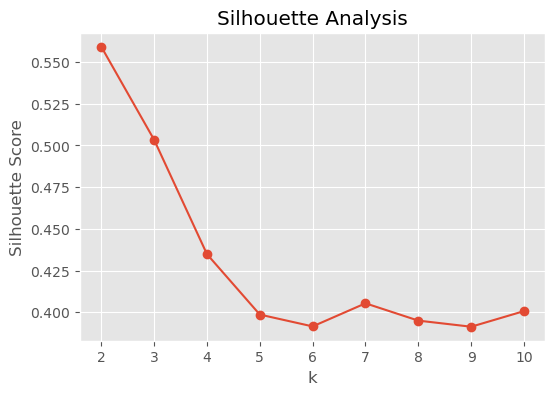

k óptimo por silhouette: 2


In [134]:
# Silhouette analysis
from sklearn.metrics import silhouette_score, adjusted_rand_score

sil_scores = []
for k in Ks:
    km = KMeans(n_clusters=k, n_init=25, random_state=495774).fit(X_reduced)
    sil_scores.append(silhouette_score(X_reduced, km.labels_))

plt.figure(figsize=(6,4))
plt.plot(Ks, sil_scores, '-o')
plt.xlabel('k'); plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

# Elegimos k que maximiza silhouette
k_opt = Ks[np.argmax(sil_scores)]
print(f"k óptimo por silhouette: {k_opt}")


In [135]:
# Creamos y entrenamos el modelo final con k_opt
# ==============================================================================
modelo_kmeans = KMeans(n_clusters=3, n_init=25, random_state=495774)
modelo_kmeans.fit(X=X_reduced_scaled)

# Realizamos la predicción
# ==============================================================================
y_predict = modelo_kmeans.predict(X=X_reduced_scaled)

Podemos representar visualmente el cambio entre los clusters originales y los que se crean con el algoritmo de K-means de la siguiente forma:

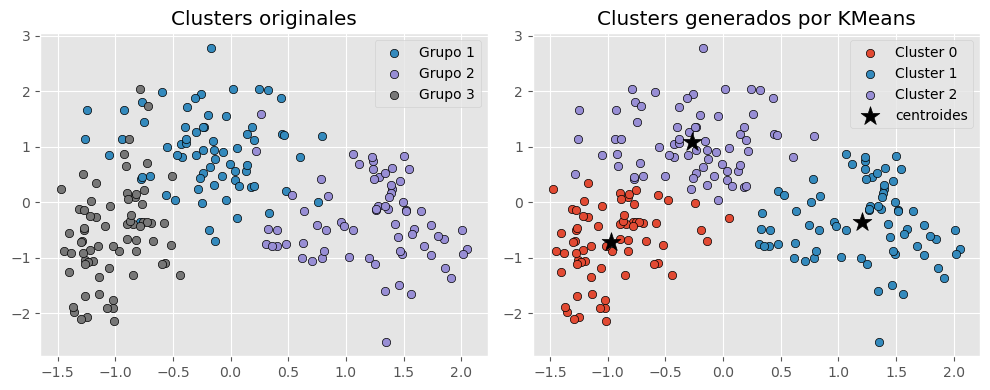

In [136]:
# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Grupos originales
for i in np.unique(y):
    ax[0].scatter(
        x = X_reduced_scaled[y == i, 0],
        y = X_reduced_scaled[y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker = 'o',
        edgecolor = 'black',
        label = f"Grupo {i}"
    )

ax[0].set_title('Clusters originales')
ax[0].legend()

# Clusters generados por KMeans
for i in np.unique(y_predict):
    ax[1].scatter(
        x = X_reduced_scaled[y_predict == i, 0],
        y = X_reduced_scaled[y_predict == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker = 'o',
        edgecolor = 'black',
        label = f"Cluster {i}"
    )

ax[1].scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label = 'centroides'
)
ax[1].set_title('Clusters generados por KMeans')
ax[1].legend()
plt.tight_layout()
plt.show()


## 2.2 Cluster Jerárquico / Dendograma

Para generar dendogramas, primero realizamos un escalado de datos:

In [137]:
# Escalado de las variables
# ==============================================================================
X_reduced_scaled = scale(X=X_reduced, axis=0, with_mean=True, with_std=True)

# Convertimos X_reduced_scaled a DataFrame para visualización
df_reduced = pd.DataFrame(X_reduced_scaled, columns=['X1', 'X2'])

# Mostramos las primeras filas
print(df_reduced.head())

         X1        X2
0  0.129757  0.554504
1 -0.042026  1.556821
2 -0.258332  1.951788
3 -0.312819  1.883636
4  0.433374  1.886796


Aquí tenemos la función que se encargará de representar el dendograma de un conjunto de datos:

In [138]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    dendrogram(linkage_matrix, **kwargs)

### 2.2.1 Selección de linkage con dendrogramas

Probamos **ward**, **complete** y **average** con **distance_threshold=0**, luego truncamos a nivel 5.

Cuando aplicamos un clustering jerárquico debemos de escoger el tipo de linkage y la distancia. Entonces vamos creando diferentes modelos que utilicen distintos valores de esos conceptos expuestos y escogeremos el mejor de todos: 

In [139]:
from sklearn.cluster import AgglomerativeClustering

# Modelos
# ==============================================================================
modelo_hclust_complete = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'complete',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_complete.fit(X=X_reduced_scaled)

modelo_hclust_average = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'average',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_average.fit(X=X_reduced_scaled)

modelo_hclust_ward = AgglomerativeClustering(
    linkage  = 'ward',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_ward.fit(X=X_reduced_scaled)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

Ahora generamos los dendogramas de cada modelo:

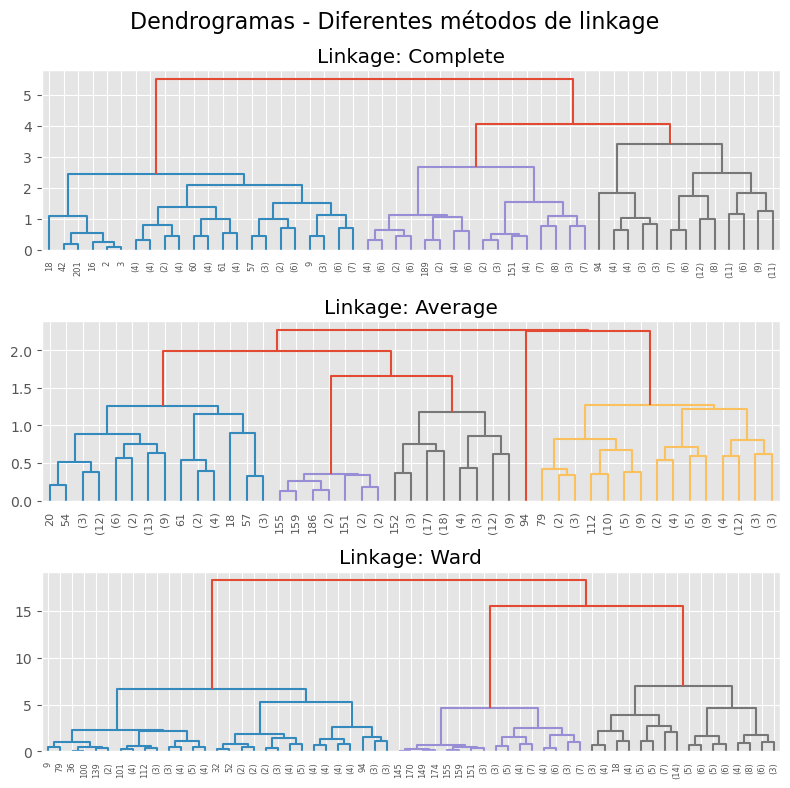

In [140]:
# Dibujamos los dendrogramas
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
fig.suptitle('Dendrogramas - Diferentes métodos de linkage', fontsize=16)

plt.sca(axs[0])
plot_dendrogram(modelo_hclust_complete, truncate_mode="level", p=5)
plt.title("Linkage: Complete")

plt.sca(axs[1])
plot_dendrogram(modelo_hclust_average, truncate_mode="level", p=5)
plt.title("Linkage: Average")

plt.sca(axs[2])
plot_dendrogram(modelo_hclust_ward, truncate_mode="level", p=5)
plt.title("Linkage: Ward")

plt.tight_layout()
plt.show()

### 2.2 Silhouette para cada linkage y distintos n_clusters

Para elegir entre los tres tipos de linkage (Complete, Average o Ward), podemos hacer uso de métricas como el silhouette score.

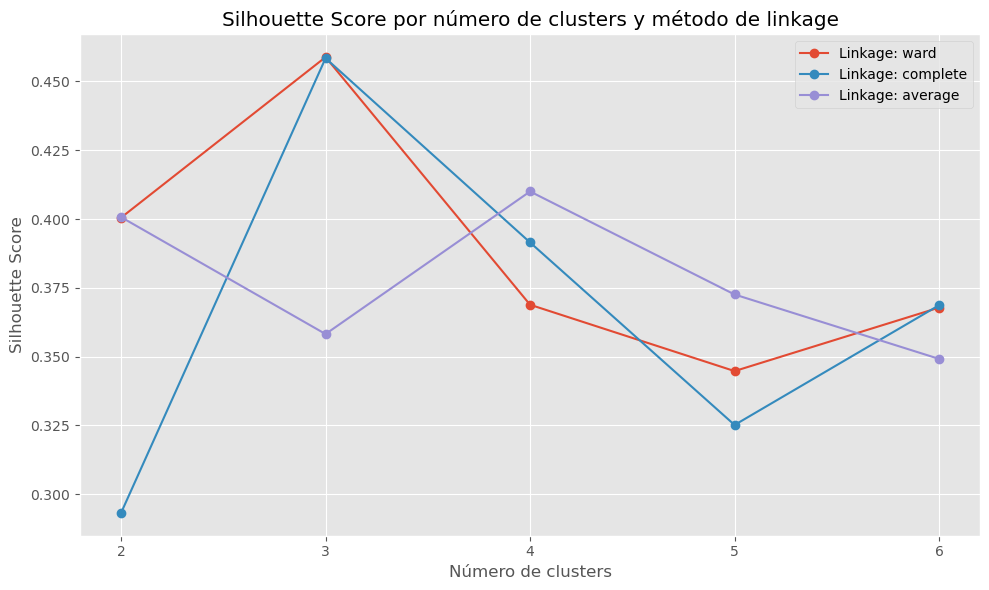

In [141]:
from sklearn.metrics import silhouette_score

# Parámetros
n_clusters_range = range(2, 7)
linkages = ['ward', 'complete', 'average']

# Diccionario para guardar los resultados
results = {linkage: [] for linkage in linkages}

# Calculamos los silhouette scores
for linkage in linkages:
    for n_clusters in n_clusters_range:
        if linkage == 'ward':
            model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        else:
            model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, metric='euclidean')
        labels = model.fit_predict(X_reduced_scaled)
        score = silhouette_score(X_reduced_scaled, labels)
        results[linkage].append(score)

# Mostramos los resultados
plt.figure(figsize=(10, 6))
for linkage in linkages:
    plt.plot(n_clusters_range, results[linkage], marker='o', label=f'Linkage: {linkage}')

plt.title('Silhouette Score por número de clusters y método de linkage')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.xticks(n_clusters_range)  # <-- aquí se fija el paso del eje X a 1 en 1
plt.tight_layout()
plt.show()


Hemos probado los tres tipos de linkage (ward, average y complete) usando datos reducidos a dos dimensiones mediante PCA. Al evaluar la calidad de los clusters mediante el silhouette score con distintos números de clusters, el modelo con linkage 'ward' obtuvo el valor más alto, por lo que, junto con un n_clusters = 3, lo seleccionamos como el modelo jerárquico final.

In [142]:
# Modelo final
# ==============================================================================
modelo_hclust_ward = AgglomerativeClustering(
    linkage  = 'ward',
    n_clusters = 3
)
modelo_hclust_ward.fit(X=X_reduced_scaled)

AgglomerativeClustering(n_clusters=3)

## 2.3 Clustering basado en densidad / DBSCAN

Primero vamos a visualizar los datos, ya escalados en X_reduced_scaled

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Nube de puntos iniciales')

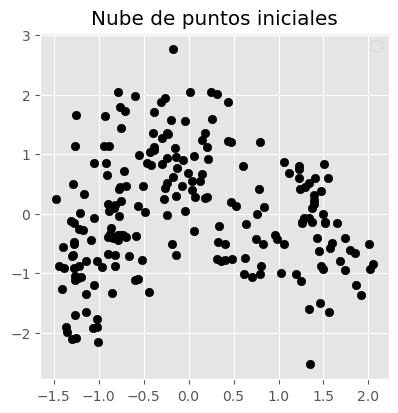

In [143]:
# Visualizado de datos
# ==============================================================================

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X_reduced_scaled[:, 0],
    y = X_reduced_scaled[:, 1],
    c = 'black',
    marker    = 'o',
    edgecolor = 'black'
)
ax.legend()
ax.set_title('Nube de puntos iniciales')

Text(0.5, 1.0, 'Clusterings generados por DBSCAN')

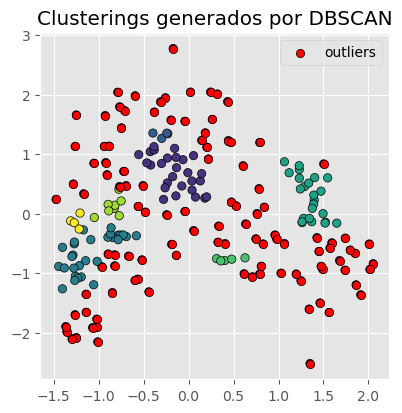

In [ ]:
from sklearn.cluster import DBSCAN

# Modelo
# ==============================================================================
modelo_dbscan = DBSCAN(
    eps          = 0.2,
    min_samples  = 5,
    metric       = 'euclidean',
)

modelo_dbscan.fit(X=X_reduced_scaled)

# Clasificación
# ==============================================================================
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X_reduced_scaled[:, 0],
    y = X_reduced_scaled[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X_reduced_scaled[labels == -1, 0],
    y = X_reduced_scaled[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN')

De esta gráfica podemos sacar el número de clusters y de outliers que existen:

In [145]:
# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')

Número de clusters encontrados: 7
Número de outliers encontrados: 109


Ahora debemos determinar un valor correcto del hiperparámetro EPS (epsilon). Este hiperparámetro determina el radio máximo para determinar vecinos. Es decir, que si dos puntos se encuentran a una distancia menor o igual a ese EPS, son vecinos. La influencia de epsilon se puede explicar de la siguiente forma:

 - eps pequeño → solo puntos muy cercanos forman grupos → más clusters pequeños o incluso mucho ruido (puntos sin cluster).
 - eps grande → más puntos considerados vecinos → menos clusters, aglomeraciones más grandes.

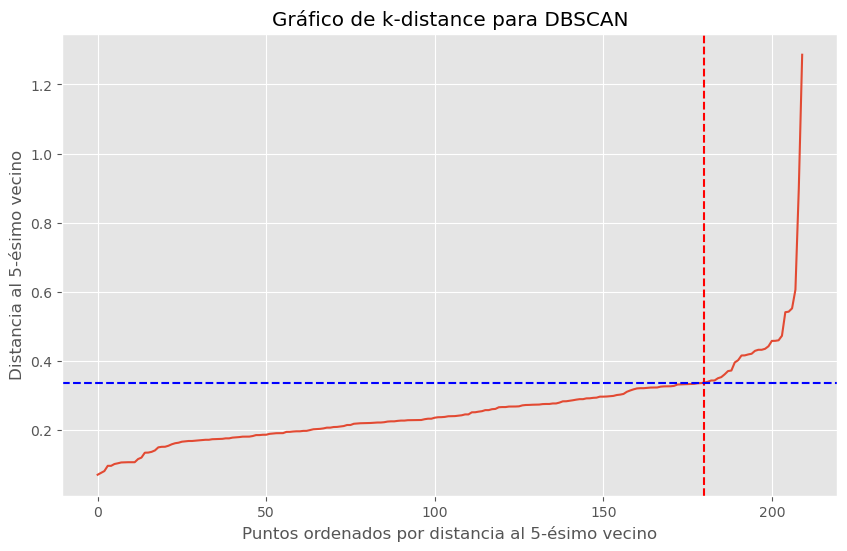

eps sugerido ≈ 0.338


In [146]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

min_samples = 5

# Ajustamos el modelo de vecinos más cercanos
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_reduced_scaled)
distances, indices = nn.kneighbors(X_reduced_scaled)

# Ordenamos las distancias del min_samples-ésimo vecino
sorted_distances = np.sort(distances[:, min_samples - 1])

# Elegimos un punto cerca del "codo" (ajustar si es necesario)
x_point = len(sorted_distances) - 30
y_value = sorted_distances[x_point]

# Gráfico de k-distancia
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.axvline(x=x_point, color='r', linestyle='--')
plt.axhline(y=y_value, color='b', linestyle='--')
plt.title('Gráfico de k-distance para DBSCAN')
plt.xlabel(f'Puntos ordenados por distancia al {min_samples}-ésimo vecino')
plt.ylabel(f'Distancia al {min_samples}-ésimo vecino')
plt.grid(True)
plt.show()

print(f"eps sugerido ≈ {y_value:.3f}")


Ahora utilizamos ese epsilon sugerido (0.338) y aplicamos el DBSCAN final:

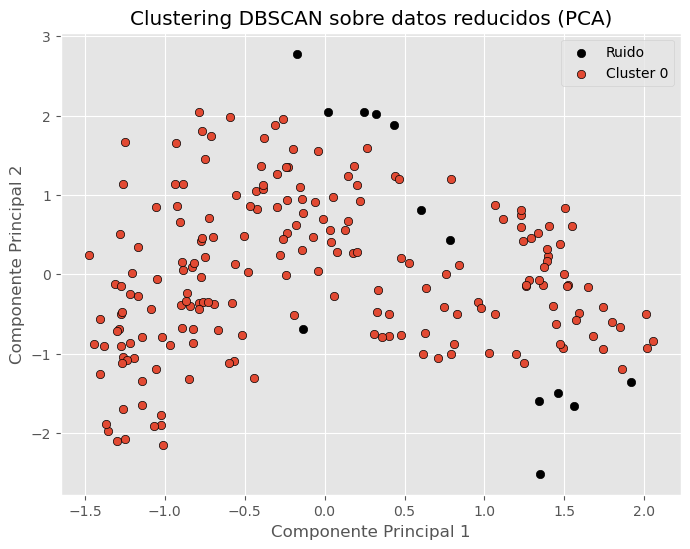

In [147]:

# Usamos el eps visualizado
eps_optimo = y_value

modelo_dbscan = DBSCAN(eps=eps_optimo, min_samples=min_samples)
modelo_dbscan.fit(X_reduced_scaled)

# Etiquetas asignadas a cada punto (-1 es ruido)
labels_dbscan = modelo_dbscan.labels_

# Visualizamos los clusters
plt.figure(figsize=(8, 6))

for cluster_id in np.unique(labels_dbscan):
    cluster_mask = labels_dbscan == cluster_id
    color = 'black' if cluster_id == -1 else None  # Ruido en negro
    plt.scatter(
        X_reduced_scaled[cluster_mask, 0],
        X_reduced_scaled[cluster_mask, 1],
        label=f"Cluster {cluster_id}" if cluster_id != -1 else "Ruido",
        edgecolor='k',
        c=color
    )

plt.title('Clustering DBSCAN sobre datos reducidos (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.show()


# 3. Análisis de métodos de clustering

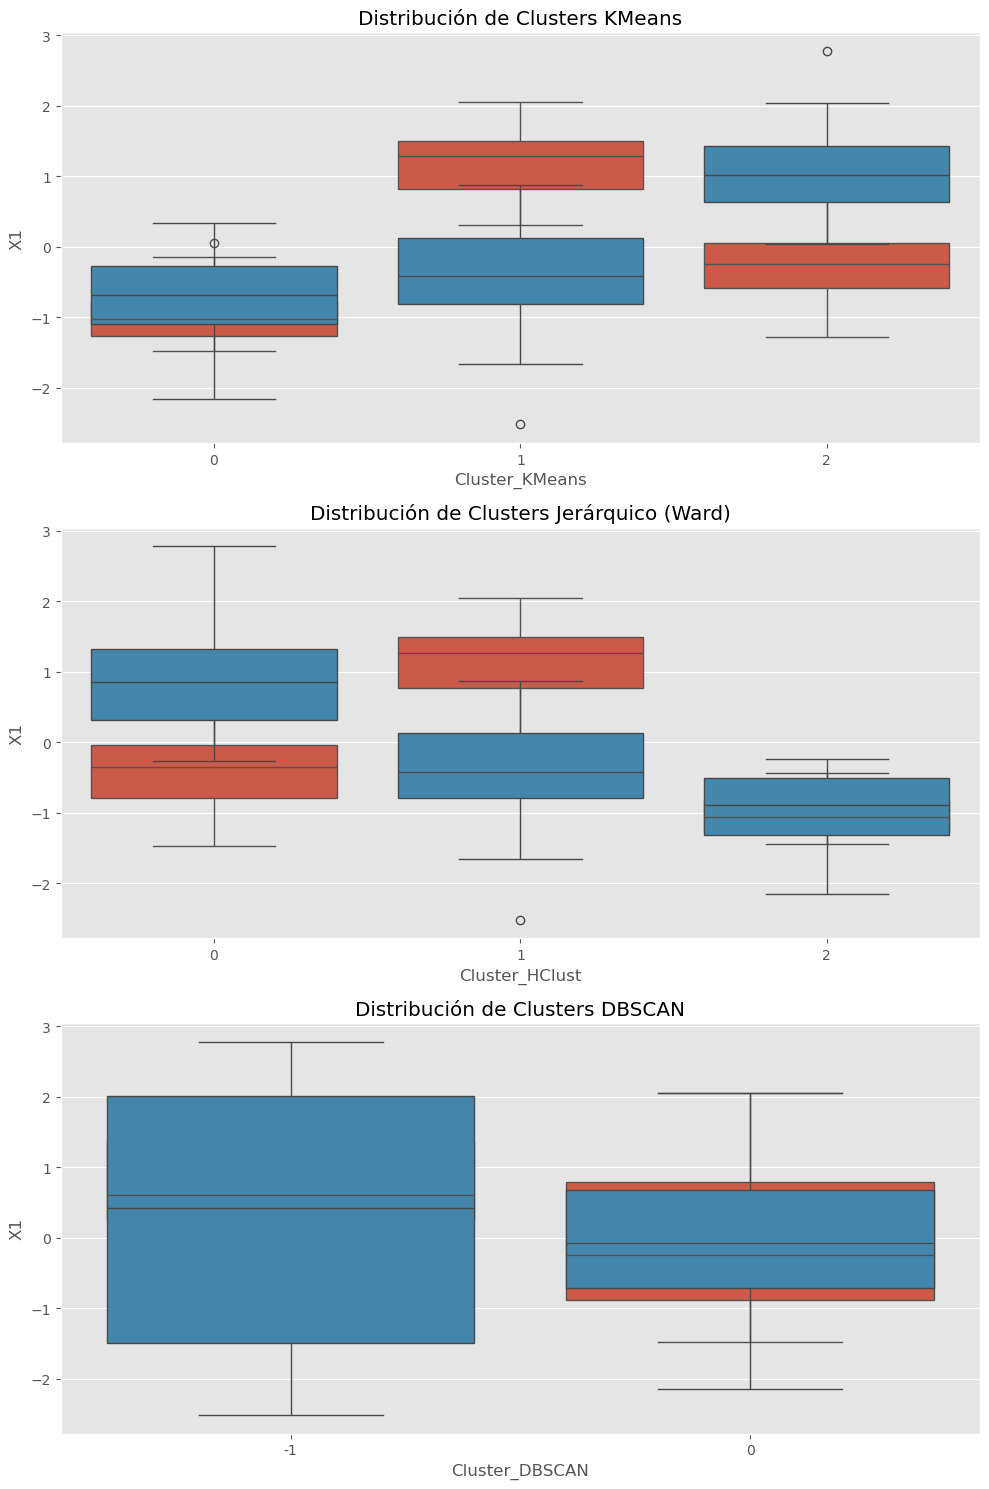

In [148]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Suponiendo que `y` contiene las clases originales (etiquetas de semillas)
# y `X_reduced_scaled` son los datos reducidos en 2 dimensiones

# Convertimos los clusters generados por los 3 métodos y las clases originales a DataFrames
kmeans_df = pd.DataFrame({'Cluster_KMeans': modelo_kmeans.labels_, 'Clase_Original': y, 'X1': X_reduced_scaled[:, 0], 'X2': X_reduced_scaled[:, 1]})
hclust_df = pd.DataFrame({'Cluster_HClust': modelo_hclust_ward.labels_, 'Clase_Original': y, 'X1': X_reduced_scaled[:, 0], 'X2': X_reduced_scaled[:, 1]})
dbscan_df = pd.DataFrame({'Cluster_DBSCAN': modelo_dbscan.labels_, 'Clase_Original': y, 'X1': X_reduced_scaled[:, 0], 'X2': X_reduced_scaled[:, 1]})

# === Boxplots para comparar distribución de los clusters ===
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# KMeans
sns.boxplot(data=kmeans_df, x='Cluster_KMeans', y='X1', ax=axs[0])
sns.boxplot(data=kmeans_df, x='Cluster_KMeans', y='X2', ax=axs[0])
axs[0].set_title('Distribución de Clusters KMeans')

# HClust
sns.boxplot(data=hclust_df, x='Cluster_HClust', y='X1', ax=axs[1])
sns.boxplot(data=hclust_df, x='Cluster_HClust', y='X2', ax=axs[1])
axs[1].set_title('Distribución de Clusters Jerárquico (Ward)')

# DBSCAN
sns.boxplot(data=dbscan_df, x='Cluster_DBSCAN', y='X1', ax=axs[2])
sns.boxplot(data=dbscan_df, x='Cluster_DBSCAN', y='X2', ax=axs[2])
axs[2].set_title('Distribución de Clusters DBSCAN')

plt.tight_layout()
plt.show()
